
# Práctica 2: Implementación de Algoritmos  
**Grado en Inteligencia Artificial**  
**Guillermo Blanco Núñez**<br>
*16/11/2025*

La práctica consiste en implementar operaciones de procesado de imagen vistas en clase con el objetivo de comprender su funcionamiento y sus efectos sobre las imagenes de entrada.

---


In [22]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import io, color, img_as_float
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.signal.windows import gaussian
from scipy.ndimage import gaussian_filter


## 2.1. Filtrado espacial: suavizado

### Función 1: 

Implementar una función que calcule un kernel Gaussiano unidimensional con σ dado.

In [23]:

def gaussianFilterSpatial1D(sigma):
    if sigma <= 0:
        raise ValueError("sigma debe ser > 0")

    N = int(2 * np.ceil(3 * sigma) + 1)
    center = N // 2
    kernel = np.zeros(N)
    for i in range(N):
        x = i - center
        kernel[i] = np.exp(-(x**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

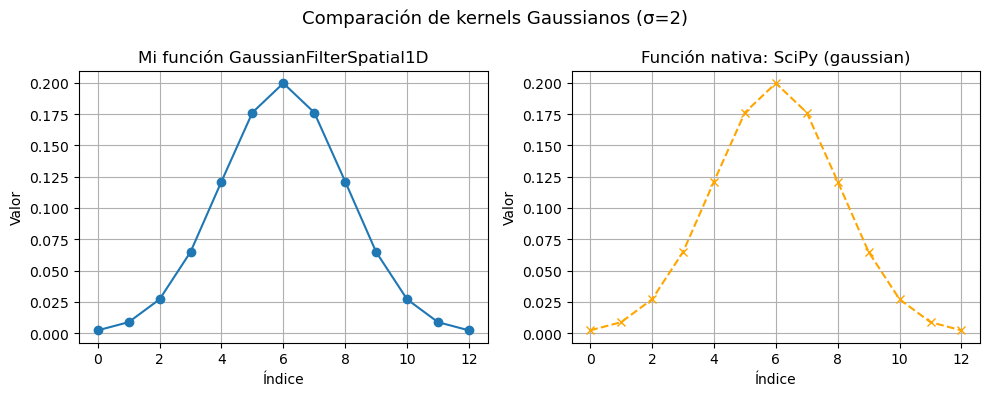

Vector de diferencias: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [24]:
# Ejemplo
sigma = 2


my_kernel = gaussianFilterSpatial1D(sigma)
N = int(2 * np.ceil(3 * sigma) + 1)
native_kernel = gaussian(N, std=sigma)
native_kernel /= np.sum(native_kernel)


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(my_kernel, marker='o')
axes[0].set_title('Mi función GaussianFilterSpatial1D')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('Valor')
axes[0].grid(True)

axes[1].plot(native_kernel, color='orange', linestyle='--', marker='x')
axes[1].set_title('Función nativa: SciPy (gaussian)')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Valor')
axes[1].grid(True)

plt.suptitle(f'Comparación de kernels Gaussianos (σ={sigma})', fontsize=13)
plt.tight_layout()
plt.show()



print("Vector de diferencias:", np.abs(my_kernel - native_kernel))

### Función 2:

Implementar una función que permita realizar un suavizado Gaussiano bidimensional usando un filtro N × N de parámetro σ, donde N se calcula igual que en la función anterior.

In [25]:

def ApplyGaussianFilterSpatial(inImage, sigma):
    kernel = gaussianFilterSpatial1D(sigma)
    temp = convolve2d(inImage, kernel[np.newaxis, :], mode='same', boundary='symm')
    outImage = convolve2d(temp, kernel[:, np.newaxis], mode='same', boundary='symm')
    return outImage

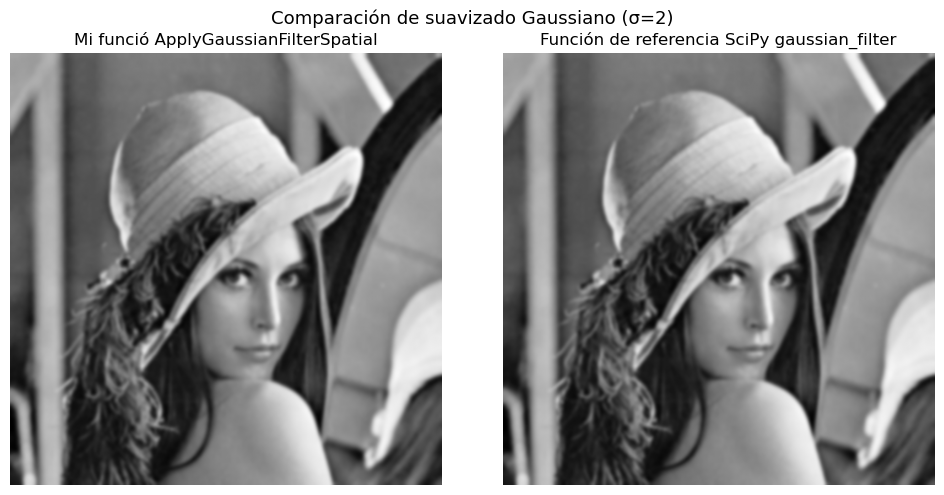

¿Son casi iguales?: True
Diferencia media absoluta: 6.861553770928318e-05


In [26]:
# Ejemplo
sigma = 2
test_img = img_as_float(io.imread('../PVC_Pract1/Material Adicional/lena.png', as_gray=True))
my_filtered = ApplyGaussianFilterSpatial(test_img, sigma)
ref_filtered = gaussian_filter(test_img, sigma=sigma)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(my_filtered, cmap='gray')
axes[0].set_title('Mi funció ApplyGaussianFilterSpatial')
axes[0].axis('off')

axes[1].imshow(ref_filtered, cmap='gray')
axes[1].set_title('Función de referencia SciPy gaussian_filter')
axes[1].axis('off')

plt.suptitle(f'Comparación de suavizado Gaussiano (σ={sigma})', fontsize=13)
plt.tight_layout()
plt.show()



print("¿Son casi iguales?:", np.allclose(my_filtered, ref_filtered, atol=1e-3))
print("Diferencia media absoluta:", np.mean(np.abs(my_filtered - ref_filtered)))


###  Función 3: 

Implementar una función que calcule un filtro gaussiano en frecuencia, de tamaño N × M y un σ dado.

In [27]:

def gaussianFilterFrec(inImage, sigma):
    N, M = inImage.shape[:2]
    u = np.arange(-N//2, N//2)
    v = np.arange(-M//2, M//2)
    U, V = np.meshgrid(u, v, indexing="ij")

    Fu = U / N
    Fv = V / M

    H = np.exp(-2 * (np.pi**2) * (sigma**2) * (Fu**2 + Fv**2))

    return H



MAE: 3.0027595087320636e-08
Max diff: 2.3763063970474266e-05


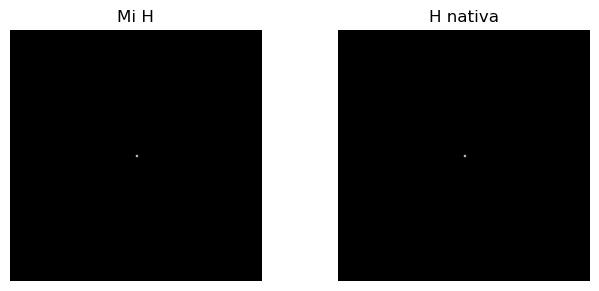

<Figure size 640x480 with 0 Axes>

In [28]:
from skimage.filters import gaussian as gaussian_spatial
np.random.seed(0)
inImage = np.random.rand(128, 128)

sigma = 150

H_mia = gaussianFilterFrec(inImage, sigma)
imp = np.zeros_like(inImage)
imp[inImage.shape[0]//2, inImage.shape[1]//2] = 1.0   # impulso en el centro

kernel_spatial = gaussian_spatial(imp, sigma, mode="reflect", preserve_range=True)
H_native = fftshift(fft2(kernel_spatial))

# --- comparación numérica ---
diff = np.abs(H_mia - H_native)
print("MAE:", diff.mean())
print("Max diff:", diff.max())

# --- comparación visual (módulo) ---
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(np.abs(H_mia), cmap="gray");    plt.title("Mi H");      plt.axis("off")
plt.subplot(1,3,2); plt.imshow(np.abs(H_native), cmap="gray"); plt.title("H nativa"); plt.axis("off")
plt.tight_layout()
plt.show()
plt.suptitle(f'Comparación de filtros Gaussianos en Frecuencia (σ={sigma})', fontsize=13)
plt.tight_layout()
plt.show()



###  Función 4: 

Implementar una función que aplique el filtro gaussiano en frecuencia anterior sobre una imagen, con el filtro del tamño de la imagen y un σ dado.


In [29]:
def ApplyGaussianFilterFrec(inImage, sigma):
    
    F = fft2(inImage)
    F_shift = fftshift(F)

    H = gaussianFilterFrec(inImage, sigma)

    G = F_shift * H
    G_ishift = ifftshift(G)
    outImage = np.real(ifft2(G_ishift))

    return outImage


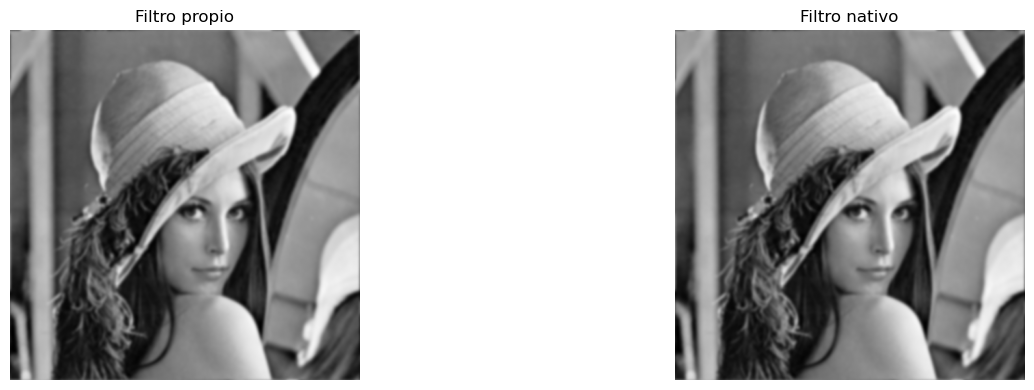

¿Son casi iguales?: True
Diferencia media absoluta: 1.5978470931815808e-06


In [30]:

from skimage.filters import gaussian as gaussian_native

inImage_color = io.imread("../PVC_Pract1/Material Adicional/lena.png")  
inImage_gray  = color.rgb2gray(inImage_color)
inImage_gray  = img_as_float(inImage_gray)

sigma = 2


out_freq = ApplyGaussianFilterFrec(inImage_gray, sigma)

out_freq = np.clip(out_freq, 0.0, 1.0)

out_native = gaussian_native(
    inImage_gray,
    sigma=sigma,
    mode="wrap",      
    preserve_range=True  
)

diff = np.abs(out_freq - out_native)
mae = diff.mean()  
mx  = diff.max()    


fig, axes = plt.subplots(1, 2, figsize=(16, 4))


axes[0].imshow(out_freq, cmap="gray")
axes[0].set_title("Filtro propio")
axes[0].axis("off")

axes[1].imshow(out_native, cmap="gray")
axes[1].set_title("Filtro nativo")
axes[1].axis("off")


plt.tight_layout()
plt.show()



print("¿Son casi iguales?:", np.allclose(out_freq, out_native, atol=1e-3))
print("Diferencia media absoluta:", np.mean(np.abs(out_freq - out_native)))
